In [1]:
# -*- coding: utf-8 -*-
'''-----------------------------------------------------------'''

import tensorflow as tf
import numpy as np
from math import *
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import norm
from IPython.display import Image, display, Math, Latex


# Params
n_inpoints = 100



C:\Users\Karma\Anaconda3\envs\tflo\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


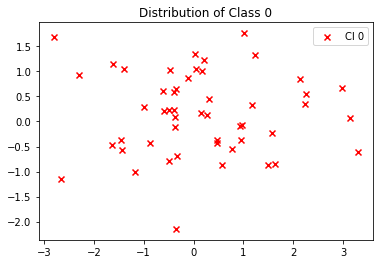

'-----------------------------------------------------------'

In [2]:
'''-----------------------------------------------------------'''
def generateClass0():
    theta0 = 0
    lmb01 = 2
    lmb02 = 1
    m0 = (0,  0)
    # computing u * u.T and later multiplying with lambda
    cov01 = [[(cos(theta0))**2,    cos(theta0)*sin(theta0)],
             [(sin(theta0))*cos(theta0), (sin(theta0))**2]]
    cov02 = [[(sin(theta0))**2,    -(cos(theta0)*sin(theta0))],
             [-(cos(theta0)*sin(theta0)), (cos(theta0))**2]]
    cov0 = lmb01*np.matrix(cov01) + lmb02*np.matrix(cov02)
    cov0_det = np.linalg.det(cov0)
    x0, y0 = np.random.multivariate_normal(m0, cov0, int(n_inpoints/2)).T
    return x0,y0

x0, y0 = generateClass0()
plt.scatter(x0, y0, color = 'r',marker='x', label = 'Cl 0')
plt.legend()
plt.title('Distribution of Class 0')
plt.show()

'''-----------------------------------------------------------'''

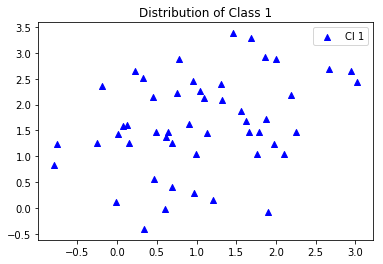

'-----------------------------------------------------------'

In [3]:
'''-----------------------------------------------------------'''
def generateClass1():
    # Mixture A
    theta1a = -3*pi/4
    lmb1a1 = 2
    lmb1a2 = 1/4
    m1a = (-2, 1)
    cov1a = [[(cos(theta1a))**2,    cos(theta1a)*sin(theta1a)],
             [(sin(theta1a))*cos(theta1a), (sin(theta1a))**2]]
    cov2a = [[(sin(theta1a))**2,    -(cos(theta1a)*sin(theta1a))],
             [-(cos(theta1a)*sin(theta1a)), (cos(theta1a))**2]]
    cov1a = lmb1a1*np.matrix(cov1a) + lmb1a2*np.matrix(cov2a)
    cov1a_det = np.linalg.det(cov1a)
    x1a, y1a = np.random.multivariate_normal(m1a, cov1a, int(n_inpoints/2)).T
    #print('Shape: ',x1a.shape,', ',y1a.shape,', ',cov1a)

    # Mixture B
    theta1b = pi/4
    lmb1b1 = 3
    lmb1b2 = 1
    m1b = (3, 2)
    cov1b = [[(cos(theta1b))**2,    cos(theta1b)*sin(theta1b)],
             [(sin(theta1b))*cos(theta1b), (sin(theta1b))**2]]
    cov2b = [[(sin(theta1b))**2,    -(cos(theta1b)*sin(theta1b))],
             [-(cos(theta1b)*sin(theta1b)), (cos(theta1b))**2]]
    cov1b = lmb1b1*np.matrix(cov1b) + lmb1b2*np.matrix(cov2b)
    cov1b_det = np.linalg.det(cov1b)
    x1b, y1b = np.random.multivariate_normal(m1b, cov1b, int(n_inpoints/2)).T
    #print('Shape: ',x1b.shape,', ',y1b.shape,', ',cov1b)

    # Class 1 (A * 0.33 +B * 0.66)
    y1 = np.array(y1a)* (1 / 3)+np.array(y1b)* (2 / 3)
    x1 = np.array(x1a)* (1 / 3)+np.array(x1b)* (2 / 3)
    return x1,y1

x1, y1 = generateClass1()
plt.scatter(x1, y1, color = 'b',marker='^', label = 'Cl 1')
plt.title('Distribution of Class 1')
plt.legend()
plt.show()

'''-----------------------------------------------------------'''

Shape; X: (100,) , Y: (100,)


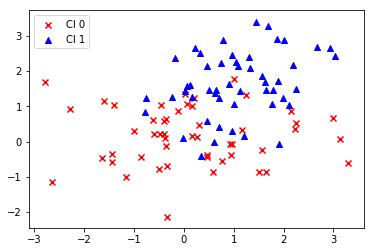

'-----------------------------------------------------------'

In [4]:
'''-----------------------------------------------------------'''
x = np.concatenate((x0, x1))
y = np.concatenate((y0, y1))
print('Shape; X:',x.shape,', Y:',y.shape)
plt.scatter(x0, y0, color = 'r',marker='x', label = 'Cl 0')
plt.scatter(x1, y1, color = 'b',marker='^', label = 'Cl 1')
plt.legend()
plt.show()

c0 = np.vstack((x0, y0)).T
c1 = np.vstack((x1, y1)).T
# ----------------------------------------
# Set up the [xi, yi] training data vector
# ----------------------------------------
X = np.concatenate((c0,c1), axis = 0)
Y = np.array([0]*int(n_inpoints/2) + [1]*int(n_inpoints/2)).reshape(n_inpoints,1)
'''-----------------------------------------------------------'''

In [29]:

# Divide the data into Train Valid, Test
tot_count = n_inpoints
trn_count = 70
val_count = 20
tst_count = 10

# Shuffle X & Y values
sfl_idx = np.arange(0,tot_count)
np.random.shuffle(sfl_idx)
#print(sfl_idx)
#print(sfl_idx[np.arange(0,10)])

Xc0 = X[:,0]
Xc = X[:,1]
Xc = Xc.reshape(tot_count,1)
print(Xc.shape)
#print(Xc)

train_X0 = Xc0[sfl_idx[np.arange(0,trn_count)]]
train_X = Xc[sfl_idx[np.arange(0,trn_count)]]
train_Y = Y[sfl_idx[np.arange(0,trn_count)]]
n_samples = train_X.shape[0]

valid_X = Xc[sfl_idx[np.arange(trn_count,trn_count+val_count)]]
valid_Y = Y[sfl_idx[np.arange(trn_count,trn_count+val_count)]]

tests_X = Xc[sfl_idx[np.arange(trn_count+val_count, tot_count)]]
tests_Y = Y[sfl_idx[np.arange(trn_count+val_count, tot_count)]]

print('Train: ',train_X.shape, train_Y.T)
print('Valid: ',valid_X.shape, valid_Y.T)
print('Tests: ',tests_X.shape, tests_Y.T)
'''-----------------------------------------------------------'''

(100, 1)
Train:  (70, 1) [[1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0
  1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1]]
Valid:  (20, 1) [[0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0]]
Tests:  (10, 1) [[0 0 0 1 0 0 0 0 1 0]]


'-----------------------------------------------------------'

In [27]:
# Parameters
learning_rate = 0.01
training_epochs = 1000
display_step = 50
rng = np.random

# tf Graph Input
Xtf = tf.placeholder(tf.float32, [None, 1])
Ytf = tf.placeholder(tf.float32, [None, 1])

# Set model weights
# figure tf.rand
# tf.keras.initializer
Wtf = tf.Variable(np.zeros([1,1]), dtype=tf.float32, name="weight")
btf = tf.Variable(np.zeros([1,1]), dtype=tf.float32, name="bias")


# Construct a linear model
predtf = tf.add(tf.matmul(Xtf, Wtf), btf)

# Mean squared error
costtf = tf.reduce_sum(tf.pow(predtf-Ytf, 2))/(2*n_samples)
# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(costtf)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()




Epoch: 0050 cost= 0.091381833 W= [[0.23561463]] b= [[0.15761903]]
Epoch: 0100 cost= 0.077617608 W= [[0.2976583]] b= [[0.20557703]]
Epoch: 0150 cost= 0.076496765 W= [[0.31243524]] b= [[0.2225022]]
Epoch: 0200 cost= 0.076360255 W= [[0.31462348]] b= [[0.23019753]]
Epoch: 0250 cost= 0.076315604 W= [[0.31369245]] b= [[0.2347921]]
Epoch: 0300 cost= 0.076289393 W= [[0.3121852]] b= [[0.23807666]]
Epoch: 0350 cost= 0.076272227 W= [[0.3107499]] b= [[0.2406283]]
Epoch: 0400 cost= 0.076260827 W= [[0.3095224]] b= [[0.24267451]]
Epoch: 0450 cost= 0.076253235 W= [[0.30850554]] b= [[0.2443339]]
Epoch: 0500 cost= 0.076248191 W= [[0.30767193]] b= [[0.24568485]]
Epoch: 0550 cost= 0.076244831 W= [[0.30699068]] b= [[0.24678595]]
Epoch: 0600 cost= 0.076242603 W= [[0.30643478]] b= [[0.2476839]]
Epoch: 0650 cost= 0.076241113 W= [[0.30598122]] b= [[0.24841626]]
Epoch: 0700 cost= 0.076240122 W= [[0.30561125]] b= [[0.24901362]]
Epoch: 0750 cost= 0.076239474 W= [[0.3053094]] b= [[0.24950089]]
Epoch: 0800 cost= 0.

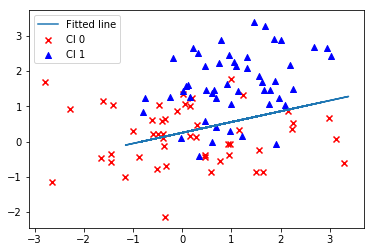

In [31]:
# Start training
with tf.Session() as sess:
    sess.run(init)

    # Fit all training data
    for epoch in range(training_epochs):
        sess.run(optimizer, feed_dict={Xtf: train_X, Ytf: train_Y})

        #Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(costtf, feed_dict={Xtf: train_X, Ytf:train_Y})
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), \
                "W=", sess.run(Wtf), "b=", sess.run(btf))

    print("Optimization Finished!")
    training_cost = sess.run(costtf, feed_dict={Xtf: train_X, Ytf: train_Y})
    print("Training cost=", training_cost, "W=", sess.run(Wtf), "b=", sess.run(btf), '\n')

    #Graphic display
    #plt.plot(train_X0, train_X, 'ro', label='Original data')
    plt.scatter(x0, y0, color = 'r',marker='x', label = 'Cl 0')
    plt.scatter(x1, y1, color = 'b',marker='^', label = 'Cl 1')
    plt.plot(train_X, sess.run(Wtf) * train_X + sess.run(btf), label='Fitted line')
    plt.legend()
    plt.show()